# Ford GoBike System Data

## by Lamees Mahmoud

## Investigation Overview

> In this analysis, I would like to investigate when are the longest and shortest trips are taken, and how user types affect the ride duration across the different time periods.

## Dataset Overview

> This dataset includes information about 2407838 individual rides made in a bike-sharing system covering the greater San Francisco Bay area during 2019. In this analysis we focus on the these features: Trip Duration, Start Time and Date, User Type. Rows that include Null or missing values are dropped also the unused columns are dropped. The Start Time and Date column is split to 3 columns timeOfDay, dayOfWeek and month. The duration column is converted from sec to min.
A subdataframe is created to hold the top routes and their coordinates.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe

# load the dataset files (a file for each month) and join them in one dataframe
files = ['01-fordgobike', '02-fordgobike', '03-fordgobike', '04-fordgobike', '05-baywheels', '06-baywheels', '07-baywheels', '08-baywheels', '09-baywheels', '10-baywheels', '11-baywheels', '12-baywheels']
path = "/content/drive/My Drive/Colab Notebooks/data_visualization/2019{month:s}-tripdata.csv"
df = pd.DataFrame()
for i in files:
  df = df.append(pd.read_csv(path.format(month = i)), ignore_index=True);

# drop unused columns
df = df.drop(['end_time', 'start_station_id', 'end_station_id', 'bike_id', 'bike_share_for_all_trip', 'rental_access_method'], axis=1)

# drop nulls
df.dropna(inplace=True);

# drop zero values in the latitudes and longitudes
df = df[(df['start_station_latitude'] != 0) & (df['start_station_longitude'] != 0) & (df['end_station_latitude'] != 0) & (df['end_station_longitude'] != 0)]

# convert the start_time to a datetime format
df['start_time'] = pd.to_datetime(df['start_time'], infer_datetime_format=True)

# create a new column for the month and day of the week (extracted from the start_time)
df['month'] = pd.DatetimeIndex(df['start_time']).month
df['dayOfWeek'] = pd.DatetimeIndex(df['start_time']).day_name()
# create a new column for the time of day (extracted from the start_time)
df['timeOfDay'] = 'night'
df.loc[(df['start_time'].dt.hour >= 5) & (df['start_time'].dt.hour <= 11), ['timeOfDay']] = 'morning'
df.loc[(df['start_time'].dt.hour >= 12) & (df['start_time'].dt.hour <= 17), ['timeOfDay']] = 'afternoon'

# convert the ride duration from sec to min so it would be easier to understand on the plots
df['duration_sec'] = df['duration_sec'] / 60
df.rename(columns={'duration_sec':'duration_min'}, inplace=True)

# convert timeOfDay into ordered categorical type
order = ['morning', 'afternoon', 'night']
ordered = pd.api.types.CategoricalDtype(ordered = True, categories = order)
df['timeOfDay'] = df['timeOfDay'].astype(ordered)

# convert dayOfWeek into ordered categorical type
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ordered = pd.api.types.CategoricalDtype(ordered = True, categories = order)
df['dayOfWeek'] = df['dayOfWeek'].astype(ordered)

## The average ride duration:

> Plotting duration on a logarithmic scale and limiting the x axis to 200 minutes; we find that the ride duration follows an approximately log-normal distribution with an average around 10 minutes.

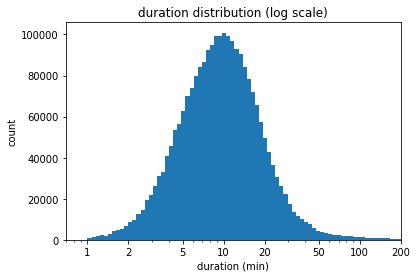

In [4]:
bin_edges = 10 ** np.arange(np.log10(df['duration_min'].min()), np.log10(df['duration_min'].max())+0.03, 0.03)
plt.hist(data = df, x = 'duration_min', bins = bin_edges);
plt.xscale('log');
tick_locs = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000];
plt.xticks(tick_locs, tick_locs);
plt.xlim(0, 200);
plt.title('duration distribution (log scale)');
plt.xlabel('duration (min)');
plt.ylabel('count');

## The percentage each user type represents

> - customers' rides represent 19.6% of the total rides.
- subscribers' rides represent 80.4% of the total rides.

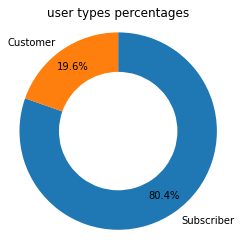

In [5]:
sorted_counts = df['user_type'].value_counts();
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90,
        counterclock = False, wedgeprops = {'width' : 0.4}, autopct='%1.1f%%', pctdistance = 0.8);
plt.axis('square');
plt.title('user types percentages');

## Duration vs month for dayOfWeek(column) and timeOfDay(row) for each user type

> - longest ride are in the weekend aftenoons during spring till midsummer.
- the shortest ride are in december.
- customers' ride duration averages are always longer than subscribers.
- subscribers' ride duration averages vary slightly around 10 minutes, while customers' ride duration averages vary in a longer range.



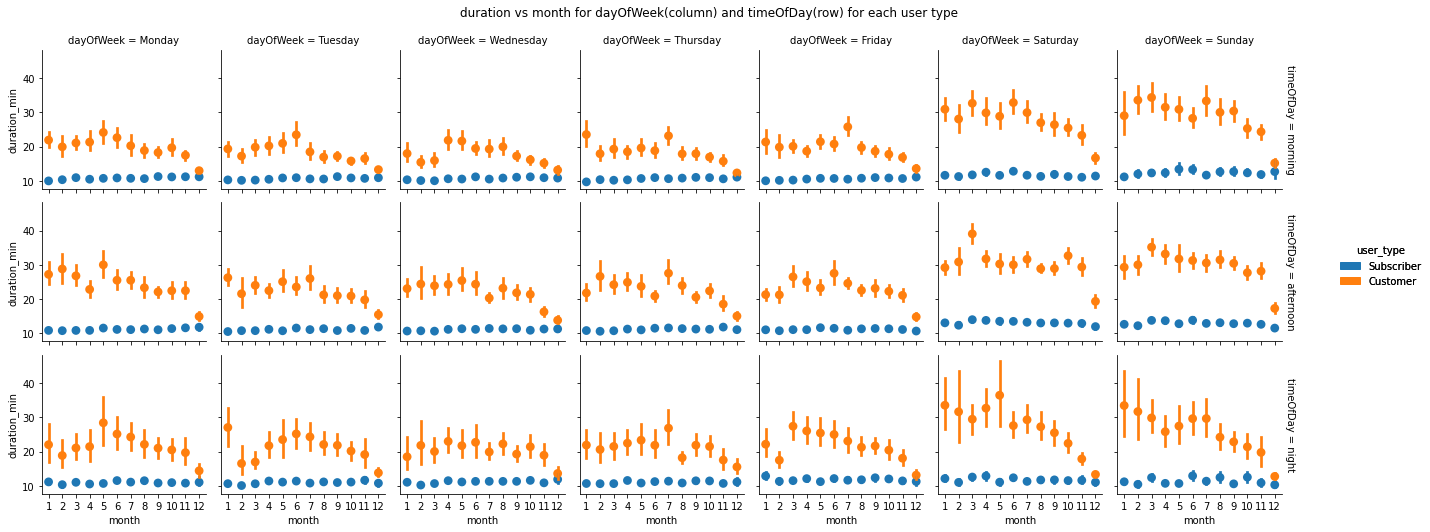

In [29]:
hue_order = ['Subscriber', 'Customer']

g = sb.FacetGrid(data = df, col = 'dayOfWeek', row = 'timeOfDay', size = 2.5,
                margin_titles = True, hue = 'user_type', hue_order = hue_order, legend_out = True);
g.map(sb.pointplot, 'month', 'duration_min', linestyles = '', dodge = 0.4).add_legend();

# get the labels limit the color to the no of labels and create the handles
labels = hue_order
colors = sb.color_palette('tab10').as_hex()[:len(labels)]
handles = [patches.Patch(color=col, label=lab) for col, lab in zip(colors, labels)]
g.add_legend(legend_data= {lab: hand for lab, hand in zip(labels, handles)});

# add title
plt.subplots_adjust(top=0.9);
g.fig.suptitle('duration vs month for dayOfWeek(column) and timeOfDay(row) for each user type');

## Conclusion

> - when analyzed separately, the user types average durations vary differently across the different times, this makes sense because subscribers and customers use the bikes for different reasons.
- subscribers probably use the bikes to get to places (instead of cars) and for daily exercise, while customers could be tourist visiting San Francisco Bay area for spring or summer and using the bikes for fun or they could be people using the bikes from time to time but not regularly.
- to gain more insight of why customers' rides are longer than subscribers' rides I think we need to collect more data about the users, this would help the company to maybe create more types of subscribtions that would suite a more people.